In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mysql.connector as con
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

In [2]:
class Connection:
    @staticmethod
    def getCon():
        try:
            db_connection = con.connect(
                host="localhost",
                user="root",
                password="alpha",
                database="academiq"
            )
            return db_connection
        except con.Error as e:
            print(f"[Error] Failed to connect to the database: {e}")
            return None

In [3]:
class Faculty:
    
    def getPerformance(self, sid, student):
        try:
            con = Connection.getCon()
            cursor = con.cursor()
            cursor1 = con.cursor()
            query = "SELECT semester, marks FROM past_marks WHERE enrollment_no=%s;"
            cursor1.execute(query, (sid,))
            fetched_data = cursor1.fetchall()

            cursor.execute("SELECT subject_id, marks FROM practical_marks WHERE enrollment_no=%s;",(sid,))
            practical_data=cursor.fetchall()
            
            if not fetched_data:
                print("No past performance data found for this student.")
                return

            subject_ids = []
            marks = []

            for row in practical_data:
                subject_ids.append(row[0])
                marks.append(row[1]) 
                
            columns = [col[0] for col in cursor1.description]
            df = pd.DataFrame(fetched_data, columns=columns)
            semester_wise_sum = df.groupby('semester')['marks'].sum().reset_index()
            plt.figure(figsize=(12, 5))

            plt.subplot(1, 2, 1)     # 1 row, 2 columns, 1st subplot
            plt.bar(semester_wise_sum['semester'], semester_wise_sum['marks'], color='royalblue', edgecolor='black')
            plt.xlabel("Semester", fontsize=12)
            plt.ylabel("Total Marks", fontsize=12)
            plt.title("Total Marks vs Semester", fontsize=14, weight="bold")
            plt.xticks(semester_wise_sum['semester'])
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            positions=range(len(subject_ids))
            plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
            plt.bar(positions, marks, color='darkorange', edgecolor='black')
            plt.xlabel("Subject ID", fontsize=12)
            plt.ylabel("Marks", fontsize=12)
            plt.title("Practical Marks per Subject", fontsize=14, weight="bold")
            plt.xticks(positions,subject_ids,rotation=45)
            plt.grid(axis="y", linestyle="--", alpha=0.7)
            
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"An error occurred while fetching performance: {e}")

    def top_low_performers(self, target_sem):
        try:
            if target_sem == 3:
                sems = [1, 2]
            elif target_sem == 5:
                sems = [1, 2, 3, 4]
            elif target_sem == 7:
                sems = [1, 2, 3, 4, 5, 6]
            else:
                print("Invalid semester. Please choose from 3, 5, or 7.")
                return

            con = Connection.getCon()
            cursor = con.cursor()
            query = "SELECT enrollment_no, semester, marks FROM past_marks WHERE semester IN (%s);" % ','.join(['%s'] * len(sems))
            cursor.execute(query, tuple(sems))
            data = cursor.fetchall()

            if not data:
                print("No records found for the selected semesters.")
                return

            columns = [col[0] for col in cursor.description]
            df = pd.DataFrame(data, columns=columns)
            semester_wise_sum = df.groupby(['enrollment_no', 'semester'])['marks'].sum().reset_index()

            results = []
            for enrollment_no in semester_wise_sum['enrollment_no'].unique():
                student_data = semester_wise_sum[semester_wise_sum['enrollment_no'] == enrollment_no].sort_values('semester')
                for i in range(1, len(student_data)):
                    prev_marks = student_data.iloc[i - 1]['marks']
                    current_marks = student_data.iloc[i]['marks']
                    percentage_change = ((current_marks - prev_marks) / prev_marks) * 100 if prev_marks != 0 else 0
                    results.append({
                        'enrollment_no': enrollment_no,
                        'from_semester': student_data.iloc[i - 1]['semester'],
                        'to_semester': student_data.iloc[i]['semester'],
                        'prev_marks': prev_marks,
                        'current_marks': current_marks,
                        'percentage_change': round(percentage_change, 2)
                    })

            if not results:
                print("No percentage changes found for the given semesters.")
                return

            result_df = pd.DataFrame(results)
            sorted_df = result_df.sort_values(by='percentage_change')
            top_performer = sorted_df.tail(5)
            low_performer = sorted_df.head(5)

            print("Top 5 Performers:")
            print(top_performer)

            print("\nLow 5 Performers:")
            print(low_performer)

            # Plot top and low performers
            plt.figure(figsize=(12, 8))

            plt.subplot(2, 1, 1)
            plt.bar(top_performer['enrollment_no'].astype(str), top_performer['percentage_change'], width=0.5, color='green')
            plt.title('Top 5 Performers')
            plt.xlabel('Student ID')
            plt.ylabel('Percentage Change (%)')
            plt.xticks(rotation=45)

            plt.subplot(2, 1, 2)
            plt.bar(low_performer['enrollment_no'].astype(str), low_performer['percentage_change'], width=0.5, color='red')
            plt.title('Low 5 Performers')
            plt.xlabel('Student ID')
            plt.ylabel('Percentage Change (%)')
            plt.xticks(rotation=45)

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"An error occurred while analyzing top/low performers: {e}")

    def marks_predictor(self, enroll, subid):
        try:
            db_con = Connection.getCon()
            cursor = db_con.cursor()
            cursor.execute("SELECT t1_marks, t2_marks, t3_marks FROM current_sem_marks WHERE enrollment_number=%s AND subject_id=%s", (enroll, subid))
            data = cursor.fetchone()

            if not data:
                print("No marks found for the given enrollment number and subject ID.")
                return

            student_df = pd.DataFrame([list(data)], columns=['t1_marks', 't2_marks', 't3_marks'])

            try:
                train_data = pd.read_csv('train_data.csv')
            except FileNotFoundError:
                print("'train_data.csv' not found. Please ensure the file exists in the directory.")
                return

            X = train_data[['t1_marks', 't2_marks', 't3_marks']]
            y = train_data['t4_marks']

            model = LinearRegression().fit(X, y)
            predicted_t4 = round(model.predict(student_df)[0])

            print(f"Predicted T4 Marks for Enrollment {enroll}, Subject {subid}: {predicted_t4:.2f}")

            x_axis = ["T1", "T2", "T3", "T4"]
            y_axis = list(data) + [predicted_t4]

            plt.figure(figsize=(8, 5))
            plt.plot(x_axis, y_axis, marker='o', linestyle='--', color='#FF5733', linewidth=2,
                     markersize=8, markerfacecolor='white', markeredgewidth=2, label='Marks')
            plt.title("Test-wise Marks Progression", fontsize=14, fontweight='bold')
            plt.xlabel("Tests", fontsize=12)
            plt.ylabel("Marks", fontsize=12)
            plt.grid(True, linestyle=':', linewidth=0.8, alpha=0.7)
            plt.ylim(0, max(y_axis) + 10)
            plt.legend(loc='upper left', fontsize=10)
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"An error occurred during marks prediction: {e}")

    def get_ranking(self, sem):
        try:
            con = Connection.getCon()
            marks_cursor = con.cursor()
            names_cursor = con.cursor()

            marks_cursor.execute(
                "SELECT enrollment_number, t1_marks, t2_marks, t3_marks FROM current_sem_marks WHERE current_sem=%s", (sem,))
            mData = marks_cursor.fetchall()

            if not mData:
                print(f"No marks data found for semester {sem}.")
                return

            names_cursor.execute("SELECT enrollment_no, name FROM student_data")
            nData = names_cursor.fetchall()

            if not nData:
                print("No student data found.")
                return

            marks_df = pd.DataFrame(mData, columns=["enrollment_number", "t1_marks", "t2_marks", "t3_marks"])
            total_marks_df = (
                marks_df.groupby("enrollment_number")[["t1_marks", "t2_marks", "t3_marks"]]
                .sum().sum(axis=1).reset_index(name="total_marks")
            )

            names_df = pd.DataFrame(nData, columns=["enrollment_number", "name"])
            merged_df = pd.merge(total_marks_df, names_df, on='enrollment_number')

            merged_df = merged_df.sort_values(by="total_marks", ascending=False).reset_index(drop=True)
            merged_df.insert(0, "rank", merged_df.index + 1)
            merged_df = merged_df[["rank", "enrollment_number", "name", "total_marks"]]

            filename = f"semester_{sem}_ranking.csv"
            merged_df.to_csv(filename, index=False)
            print(f"Ranking successfully saved to '{filename}'.")

        except Exception as e:
            print(f"An error occurred while generating the ranking: {e}")
        finally:
            con.close()


In [4]:
class FacultyDashboard(Faculty):
    def __init__(self):
        while True:
            print("\n---- Welcome ----")
            print("1. Individual Student Performance(Sem 3,5,7)")
            print("2. Semester-wise Star and Low Performer")
            print("3. Marks Predictor")
            print("4. Current Rank List")
            print("0. Exit")
            
            try:
                ch = int(input("Enter your choice: "))
            except ValueError:
                print("Please enter a valid integer choice.")
                continue

            if ch == 1:
                try:
                    enroll_no = int(input("Enter Enrollment Number: "))
                    student = CheckUser.getStudentDetails(enroll_no)
                    if student:
                        self.getPerformance(enroll_no, student)
                    else:
                        print("Enrollment Number Not Found.")
                except ValueError:
                    print("Invalid input. Please enter a valid enrollment number.")

            elif ch == 2:
                try:
                    sem = int(input("Enter Semester (3, 5, 7): "))
                    if sem in [3, 5, 7]:
                        self.top_low_performers(sem)
                    else:
                        print("Enter a valid semester (3, 5, or 7).")
                except ValueError:
                    print("Please enter a valid semester number.")

            elif ch == 3:
                try:
                    enroll = int(input("Enter Enrollment Number: "))
                    sub_id = int(input("Enter Subject ID: "))
                    self.marks_predictor(enroll, sub_id)
                except ValueError:
                    print("Invalid input. Please enter numeric values.")

            elif ch == 4:
                try:
                    sem = int(input("Enter Semester for Ranking (1, 3, 5, 7): "))
                    if sem in [1, 3, 5, 7]:
                        self.get_ranking(sem)
                    else:
                        print("Please select a valid semester.")
                except ValueError:
                    print("Invalid semester input.")

            elif ch == 0:
                print("Exiting Faculty Dashboard.")
                break

            else:
                print("Invalid choice. Please select a valid option.")


In [5]:
class Student:

    def veiw_details(self, data):
        try:
            rank, total_marks = self.current_standing(data)
            
            # ANSI codes for styling
            BOLD = "\033[1m"
            RESET = "\033[0m"
            CYAN = "\033[96m"
            YELLOW = "\033[93m"
            GREEN = "\033[92m"
            
            print("\n" + "=" * 55)
            print(f"{BOLD}{CYAN}{'STUDENT DETAILS':^55}{RESET}")
            print("=" * 55)
            print(f"{YELLOW}{'Enrollment Number':<25}:{RESET} {data[0]}")
            print(f"{YELLOW}{'Name':<25}:{RESET} {data[1]}")
            print(f"{YELLOW}{'Branch':<25}:{RESET} {data[3]}")
            print(f"{YELLOW}{'Semester':<25}:{RESET} {data[4]}")
            print(f"{YELLOW}{'Total Marks (T1, T2, T3)':<25}:{RESET} {GREEN}{total_marks} / 375{RESET}")
            print(f"{YELLOW}{'Current Rank':<25}:{RESET} {BOLD}{GREEN}{rank}{RESET}")
            print(f"{YELLOW}{'Contact Number':<25}:{RESET} {data[5]}")
            print(f"{YELLOW}{'Email ID':<25}:{RESET} {data[6]}")
            print("=" * 55 + "\n")
        
        except Exception as e:
            print(f"An error occurred while viewing details: {e}")

    def current_standing(self, data):
        try:
            con = Connection.getCon()
            marks_cursor = con.cursor()
            names_cursor = con.cursor()
            
            # Fetch marks data
            marks_query = "SELECT enrollment_number, t1_marks, t2_marks, t3_marks FROM current_sem_marks WHERE current_sem=%s"
            marks_cursor.execute(marks_query, (data[4],))
            mData = marks_cursor.fetchall()

            # Fetch student names
            names_query = "SELECT enrollment_no, name FROM student_data"
            names_cursor.execute(names_query)
            nData = names_cursor.fetchall()

            # Create DataFrames
            marks_df = pd.DataFrame(mData, columns=["enrollment_number", "t1_marks", "t2_marks", "t3_marks"])
            total_marks_df = (
                marks_df.groupby("enrollment_number")[["t1_marks", "t2_marks", "t3_marks"]]
                .sum()
                .sum(axis=1)
                .reset_index(name="total_marks")
            )
            names_df = pd.DataFrame(nData, columns=["enrollment_number", "name"])
            merged_df = pd.merge(total_marks_df, names_df, on='enrollment_number').sort_values(by="total_marks", ascending=False).reset_index(drop=True)
            merged_df.insert(0, "rank", merged_df.index + 1)

            standing = merged_df[merged_df['enrollment_number'] == data[0]]
            rank = standing.iloc[0]['rank']
            total_marks = standing.iloc[0]['total_marks']
            
            return rank, total_marks

        except Exception as e:
            print(f"An error occurred while calculating current standing: {e}")
            return None, None

    def predictor(self, data, subid):
        try:
            # Step 1: Fetch data from the database
            db_con = Connection.getCon()
            cursor = db_con.cursor()
            cursor.execute(
                "SELECT t1_marks, t2_marks, t3_marks FROM current_sem_marks WHERE enrollment_number=%s AND subject_id=%s",
                (data[0], subid)
            )
            marks_data = cursor.fetchone()

            if not marks_data:
                print("No marks found for the given enrollment number and subject ID.")
                return

            # Step 2: Prepare DataFrame
            columns = ['t1_marks', 't2_marks', 't3_marks']
            student_df = pd.DataFrame([list(marks_data)], columns=columns)

            # Step 3: Load training data
            try:
                train_data = pd.read_csv('train_data.csv')
            except FileNotFoundError:
                print("'train_data.csv' not found. Ensure the file is in the correct directory.")
                return

            # Step 4: Train and predict
            X = train_data[['t1_marks', 't2_marks', 't3_marks']]
            y = train_data['t4_marks']
            model = LinearRegression().fit(X, y)
            predicted_t4 = round(model.predict(student_df)[0])

            print(f"Predicted T4 Marks for Subject {subid}: {predicted_t4:.2f}")

            # Step 5: Plot
            x_axis = ["T1", "T2", "T3", "T4"]
            y_axis = list(marks_data) + [predicted_t4]

            plt.figure(figsize=(8, 5))
            plt.plot(
                x_axis, y_axis, marker='o', linestyle='--', color='#FF5733',
                linewidth=2, markersize=8, markerfacecolor='white', markeredgewidth=2, label='Marks'
            )
            plt.title("Test-wise Marks Progression", fontsize=14, fontweight='bold')
            plt.xlabel("Tests", fontsize=12)
            plt.ylabel("Marks", fontsize=12)
            plt.grid(True, linestyle=':', linewidth=0.8, alpha=0.7)
            plt.ylim(0, max(y_axis) + 10)
            plt.legend(loc='upper left', fontsize=10)
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"An error occurred in the marks prediction process: {e}")

    def performance(self, data):
        try:
            con = Connection.getCon()
            cursor = con.cursor()
            cursor1 = con.cursor()
            cursor1.execute("SELECT semester, marks FROM past_marks WHERE enrollment_no=%s", (data[0],))
            fetched_data = cursor1.fetchall()

            cursor.execute("SELECT subject_id, marks FROM practical_marks WHERE enrollment_no=%s;",(data[0],))
            practical_data=cursor.fetchall()
            
            if not fetched_data:
                print("No past performance data found for this student.")
                return

            subject_ids = []
            marks = []

            for row in practical_data:
                subject_ids.append(row[0])
                marks.append(row[1]) 
                
            columns = [col[0] for col in cursor1.description]
            df = pd.DataFrame(fetched_data, columns=columns)
            semester_wise_sum = df.groupby('semester')['marks'].sum().reset_index()
            plt.figure(figsize=(12, 5))

            plt.subplot(1, 2, 1)     # 1 row, 2 columns, 1st subplot
            plt.bar(semester_wise_sum['semester'], semester_wise_sum['marks'], color='royalblue', edgecolor='black')
            plt.xlabel("Semester", fontsize=12)
            plt.ylabel("Total Marks", fontsize=12)
            plt.title("Total Marks vs Semester", fontsize=14, weight="bold")
            plt.xticks(semester_wise_sum['semester'])
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            positions=range(len(subject_ids))
            plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
            plt.bar(positions, marks, color='darkorange', edgecolor='black')
            plt.xlabel("Subject ID", fontsize=12)
            plt.ylabel("Marks", fontsize=12)
            plt.title("Practical Marks per Subject", fontsize=14, weight="bold")
            plt.xticks(positions,subject_ids,rotation=45)
            plt.grid(axis="y", linestyle="--", alpha=0.7)
            
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"An error occurred while displaying performance: {e}")


In [6]:
class StudentDashboard(Student):
    def __init__(self, data):
        print(f"\nWelcome, {data[1]}!\n")
        
        while True:
            try:
                print("=" * 40)
                print("Choose an option:")
                print("1. View Details")
                print("2. Predict T4 Marks")
                print("3. View Performance Till Now(Sem 3,5,7)")
                print("0. Exit")
                print("=" * 40)

                ch = int(input("Enter your choice: "))

                if ch == 1:
                    self.veiw_details(data)
                elif ch == 2:
                    try:
                        subid = int(input("Enter Subject ID: "))
                        self.predictor(data, subid)
                    except ValueError:
                        print("Invalid Subject ID. Please enter a valid integer.")
                elif ch == 3:
                    if data[4]==1:
                        print("\n No Enough Data To Show!")
                        continue
                    self.performance(data)
                elif ch == 0:
                    print("Exiting dashboard. Goodbye!")
                    break
                else:
                    print("Invalid choice. Please select from the given options.")
            except ValueError:
                print("Invalid input. Please enter a valid integer.")

In [7]:
class CheckUser:
    def login(uid, pin):
        try:
            db_con = Connection.getCon()
            cursor = db_con.cursor()
            cursor.execute("SELECT * FROM faculty WHERE fac_id=%s AND pin=%s", (uid, pin))
            user = cursor.fetchall()
            if user:
                return "faculty"
            else:
                cursor.execute("SELECT * FROM student_data WHERE enrollment_no=%s AND pin=%s", (uid, pin))
                data = cursor.fetchone()
                if data:
                    return data
                else:
                    print("User not found. Please check your credentials.")
                    return False
        except Exception as e:
            print(f"An error occurred while logging in: {e}")
            return False
        finally:
                db_con.close()
            
    def getStudentDetails(enroll):
        try:
            db_con = Connection.getCon()
            cursor = db_con.cursor()
            cursor.execute("SELECT * FROM student_data WHERE enrollment_no=%s", (enroll,))
            user = cursor.fetchone()
            if user:
                return user
            else:
                return False
        except Exception as e:
            print(f"An error occurred while fetching student details: {e}")
            return False
        finally:
                db_con.close()

Enter User ID:  9011
Enter PIN:  1234



---- Welcome ----
1. Individual Student Performance(Sem 3,5,7)
2. Semester-wise Star and Low Performer
3. Marks Predictor
4. Current Rank List
0. Exit


Enter your choice:  1
Enter Enrollment Number:  230000


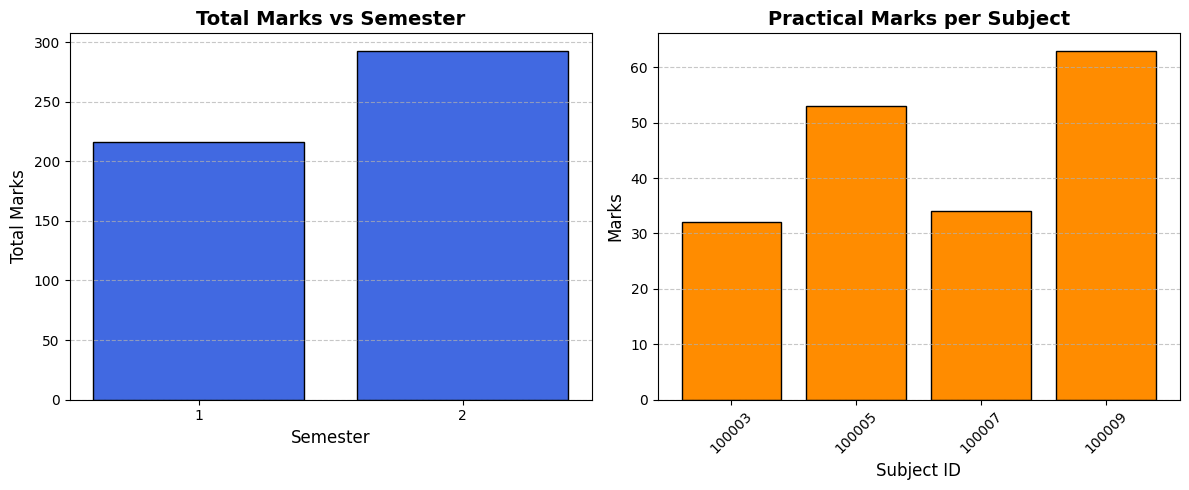


---- Welcome ----
1. Individual Student Performance(Sem 3,5,7)
2. Semester-wise Star and Low Performer
3. Marks Predictor
4. Current Rank List
0. Exit


Enter your choice:  2
Enter Semester (3, 5, 7):  3


Top 5 Performers:
     enrollment_no  from_semester  to_semester  prev_marks  current_marks  \
334         230094            1.0          2.0       140.0          448.0   
298         230058            1.0          2.0       125.0          414.0   
356         230116            1.0          2.0        81.0          271.0   
195         220075            1.0          2.0        81.0          272.0   
346         230106            1.0          2.0        85.0          364.0   

     percentage_change  
334             220.00  
298             231.20  
356             234.57  
195             235.80  
346             328.24  

Low 5 Performers:
     enrollment_no  from_semester  to_semester  prev_marks  current_marks  \
310         230070            1.0          2.0       384.0          133.0   
327         230087            1.0          2.0       265.0           95.0   
1           210001            1.0          2.0       344.0          124.0   
246         230006            1.0         

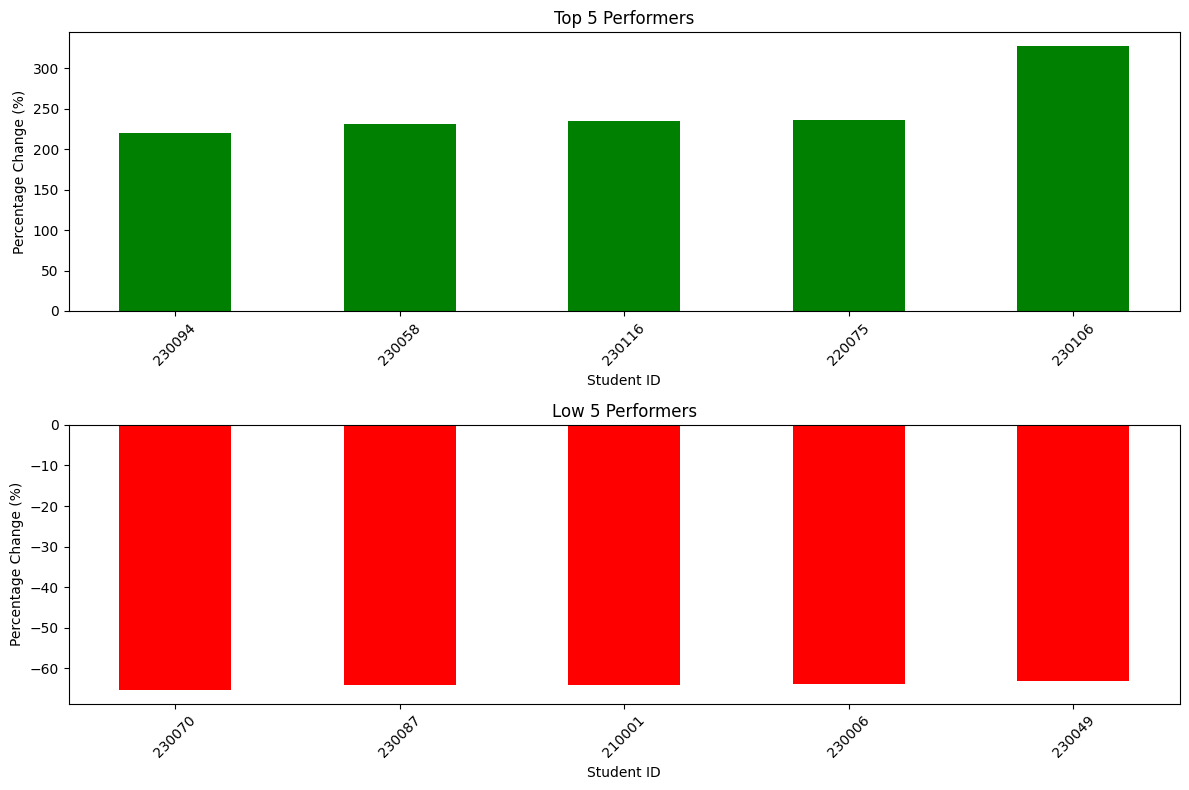


---- Welcome ----
1. Individual Student Performance(Sem 3,5,7)
2. Semester-wise Star and Low Performer
3. Marks Predictor
4. Current Rank List
0. Exit


Enter your choice:  3
Enter Enrollment Number:  230000
Enter Subject ID:  100013


Predicted T4 Marks for Enrollment 230000, Subject 100013: 15.00


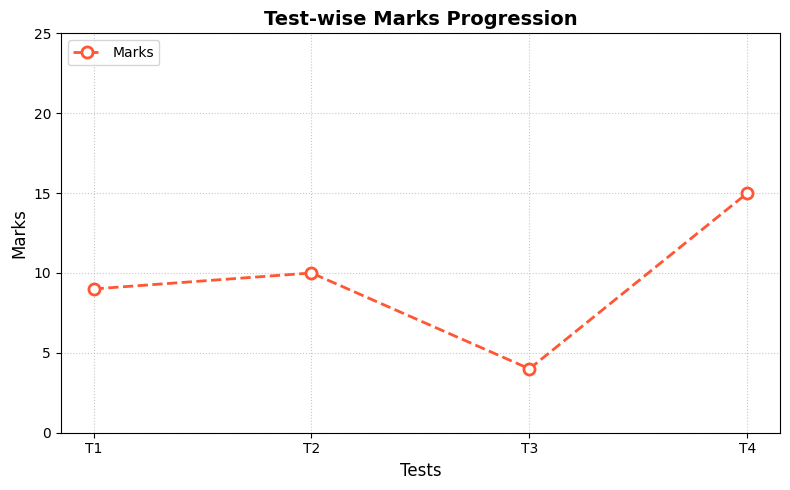


---- Welcome ----
1. Individual Student Performance(Sem 3,5,7)
2. Semester-wise Star and Low Performer
3. Marks Predictor
4. Current Rank List
0. Exit


Enter your choice:  4
Enter Semester for Ranking (1, 3, 5, 7):  7


Ranking successfully saved to 'semester_7_ranking.csv'.

---- Welcome ----
1. Individual Student Performance(Sem 3,5,7)
2. Semester-wise Star and Low Performer
3. Marks Predictor
4. Current Rank List
0. Exit


Enter your choice:  0


Exiting Faculty Dashboard.


Enter User ID:  230000
Enter PIN:  1247



Welcome, Aryan Gupta!

Choose an option:
1. View Details
2. Predict T4 Marks
3. View Performance Till Now(Sem 3,5,7)
0. Exit


Enter your choice:  1



                    STUDENT DETAILS                    
Enrollment Number        : 230000
Name                     : Aryan Gupta
Branch                   : CSE
Semester                 : 3
Total Marks (T1, T2, T3) : 171.0 / 375
Current Rank             : 93
Contact Number           : 9856731492
Email ID                 : aryangupta@example.com

Choose an option:
1. View Details
2. Predict T4 Marks
3. View Performance Till Now(Sem 3,5,7)
0. Exit


Enter your choice:  2
Enter Subject ID:  100013


Predicted T4 Marks for Subject 100013: 15.00


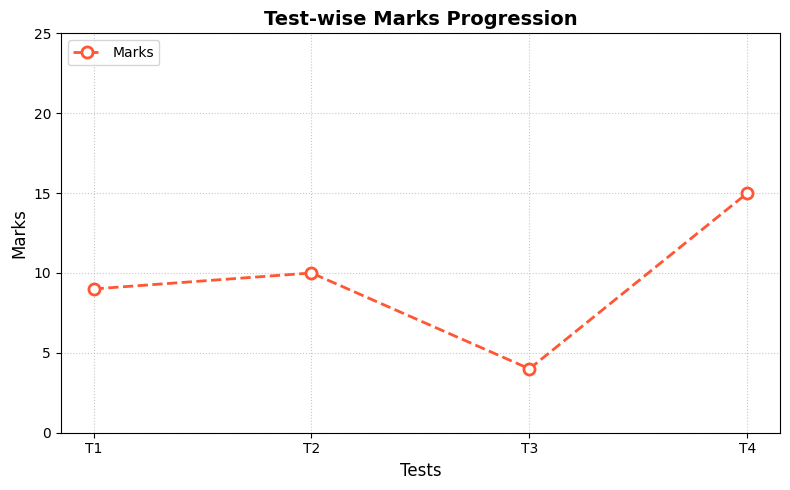

Choose an option:
1. View Details
2. Predict T4 Marks
3. View Performance Till Now(Sem 3,5,7)
0. Exit


Enter your choice:  3


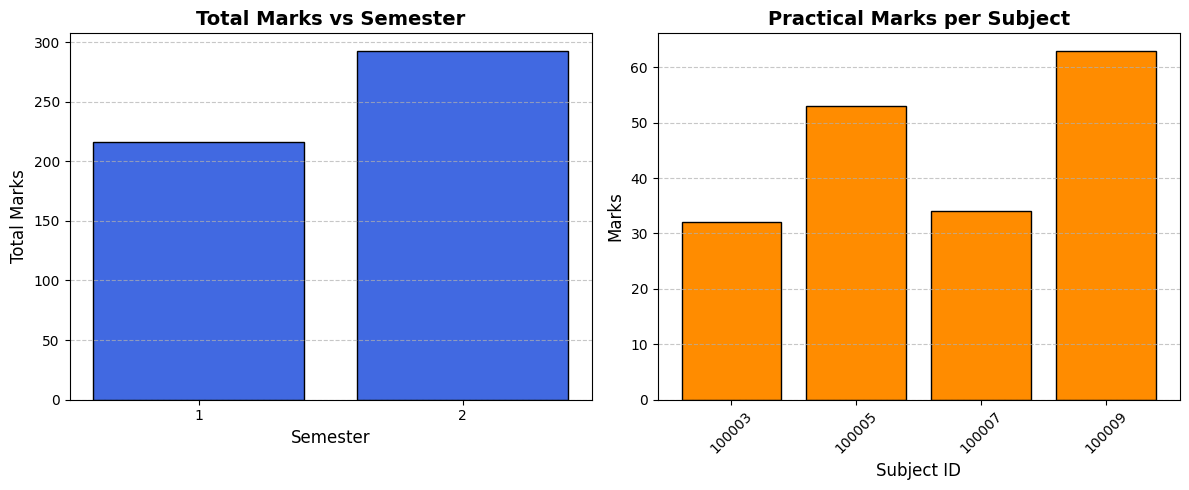

Choose an option:
1. View Details
2. Predict T4 Marks
3. View Performance Till Now(Sem 3,5,7)
0. Exit


Enter your choice:  0


Exiting dashboard. Goodbye!


In [ ]:
while True:
    try:
        userId = int(input("Enter User ID: "))
        pin = int(input("Enter PIN: "))
        user = CheckUser.login(userId, pin)
        if user:
            if user == 'faculty':
                fac = FacultyDashboard()
            else:
                student = StudentDashboard(user)
        else:
            break
    except ValueError:
        print("Invalid input. Please enter numeric values for User ID and PIN.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")